# Import Libraries

In [1]:
import os
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
#from efficientnet_pytorch import model as enet

import cv2
import timm

from tqdm import tqdm
from tqdm.notebook import tqdm

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

import logging
import time
from contextlib import contextmanager

# Config

In [2]:
class CFG:
    DATA_PATH = '../input/plant-pathology-2021-fgvc8/'
    TEST_PATH = DATA_PATH + 'test_images/'
    TRAIN_PATH = DATA_PATH + 'train_images/'
    TRAIN_CSV_PATH = DATA_PATH + 'train.csv'
    TEST_CSV_PATH = DATA_PATH + 'sample_submission.csv'
    
    MODEL_ARCH ='vit_base_patch16_224'

    IMG_SIZE = 224
    EPOCH = 10
    BATCH_SIZE = 32
    DEBUG_SIZE = 0.1
    RANDOM_STATE = 1234
    CLASS_THRESHOLD = 0.4
    DROPOUT = .4
    LR = 5e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LABELS = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
    LABELS_DICT = {
    0: 'complex', 
    1: 'frog_eye_leaf_spot',
    2: 'frog_eye_leaf_spot complex',
    3: 'frog_eye_leaf_spot',
    4: 'healthy', 
    5: 'powdery_mildew complex',
    6: 'rust',
    7: 'rust complex',
    8: 'rust frog_eye_leaf_spot',
    9: 'scab',
    10: 'scab frog_eye_leaf_spot',
    11: 'scab frog_eye_leaf_spot complex'
    }
    N_CLASS = 12

In [3]:
def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


# Load Dataframe

In [4]:
train_df = pd.read_csv(CFG.TRAIN_CSV_PATH)
sub_df = pd.read_csv(CFG.TEST_CSV_PATH)

# EDA

In [5]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [6]:
sub_df

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [7]:
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

# Visualize Image

In [8]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for x, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, x + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

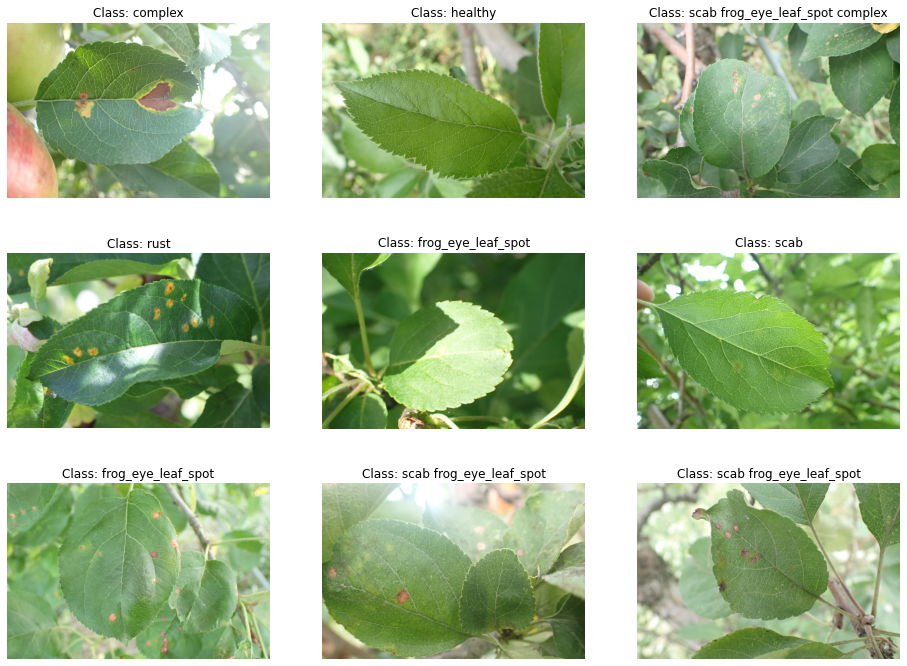

In [9]:
tmp_df = train_df.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(CFG.TRAIN_PATH,image_ids,labels)

# Encode To Unique Label

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(train_df.labels)
train_df['labels'] = le.transform(train_df.labels)

In [11]:
train_df

,image,labels
0,800113bb65efe69e.jpg,3
1,8002cb321f8bfcdf.jpg,11
2,80070f7fb5e2ccaa.jpg,9
3,80077517781fb94f.jpg,9
4,800cbf0ff87721f8.jpg,0
...,...,...
18627,fffb900a92289a33.jpg,3
18628,fffc488fa4c0e80c.jpg,9
18629,fffc94e092a59086.jpg,6
18630,fffe105cf6808292.jpg,10


In [12]:
train_df['labels']==2

0        False
1        False
2        False
3        False
4        False
         ...  
18627    False
18628    False
18629    False
18630    False
18631    False
Name: labels, Length: 18632, dtype: bool

# Seed

In [13]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

@contextmanager
def timer(name, logger=None, level=logging.DEBUG):
    print_ = print if logger is None else lambda msg: logger.log(level, msg)
    t0 = time.time()
    print_(f'[{name}] start')
    yield
    print_(f'[{name}] done in {time.time() - t0:.0f} s')

# Debug

In [14]:
DEBUG = False
if DEBUG:
    train_df= train_df.sample(frac = 0.01).reset_index(drop = True)
    print(train_df.shape)

# Split Data

In [15]:
from sklearn.model_selection import train_test_split
train, valid =  train_test_split(train_df, test_size = 0.2)
print(train.shape, valid.shape)

(14905, 2) (3727, 2)


In [16]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.labels.values
valid_targets = valid.labels.values

In [17]:
train

,image,labels
0,b42d82d64d9bf219.jpg,8
1,baa889ec267a5e1c.jpg,0
2,cd633c6f1138393c.jpg,1
3,e2ad1c3cbc375a90.jpg,6
4,95081a79b56f5aa5.jpg,9
...,...,...
14900,dda46b752573b110.jpg,9
14901,cdb4bb34924c23e9.jpg,3
14902,81f497994a696f16.jpg,10
14903,9d4a7fa4e80995a9.jpg,1


In [18]:
valid

,image,labels
0,899ccb9eac627427.jpg,3
1,896b0dc07cc2fcda.jpg,9
2,baa5c086079eaf59.jpg,9
3,bcad27d4c831d48b.jpg,9
4,8ee286b918b5b9c6.jpg,9
...,...,...
3722,878c5e9c3923c376.jpg,6
3723,9601c6f37f0e43e1.jpg,4
3724,c8e267f7136113d8.jpg,9
3725,b481dff018e7b870.jpg,3


# Dataset

In [19]:
#pytorchのDatasetクラスを継承したクラスを作成する
class TrainDataset(Dataset):
    def __init__(self, df, transform = None): #初期化
        self.df = df
        self.image_names = df["image"].values
        self.labels = df["labels"].values
        self.transform = transform
        
#データの長さを返す関数
    def __len__(self):
        return len(self.df)
    
#indexに対応する画像とラベルを返す関数
    def __getitem__(self, idx):
        image_name = self.image_names[idx] #indexに対応するimageの値
        image_path = CFG.TRAIN_PATH + image_name #indexに対応するデータのパス
        image = cv2.imread(image_path) #画像読み込み
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR→RGB
        label = self.labels[idx] #indexに対応するラベル
        #label = torch.tensor(self.labels[idx]).float()
        if self.transform: #前処理ある場合
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# Augmentation 

In [20]:
def get_transforms(data):
    
    if data == 'train':
        return Compose([
            A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            #A.RandomResizedCrop(CFG.IMG_SIZE, CFG.IMG_SIZE),
            #A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5),
            #A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            Normalize(),
            ToTensorV2(),
        ])

In [21]:
# 上で作成したデータセットクラスを呼び出す
train_dataset = TrainDataset(train, transform = get_transforms(data = 'train'))
# データセットクラスによって取り出されるデータをbatch数でまとめる
train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle = True,drop_last = True, num_workers=2)

In [22]:
train_dataset[0]

(tensor([[[0.8618, 0.7248, 0.5707,  ..., 0.7077, 0.8618, 1.1700],
          [0.9303, 0.9132, 0.6563,  ..., 0.9132, 1.1015, 1.4954],
          [0.8789, 0.9303, 0.7248,  ..., 1.2557, 1.5297, 1.6838],
          ...,
          [0.2453, 0.1768, 0.1597,  ..., 1.1872, 1.2385, 1.1872],
          [0.3138, 0.2453, 0.1597,  ..., 1.2214, 1.1872, 1.0331],
          [0.3309, 0.3138, 0.1768,  ..., 1.1529, 1.1015, 1.0159]],
 
         [[1.3606, 1.2206, 1.0805,  ..., 1.4832, 1.5532, 1.8508],
          [1.4307, 1.4307, 1.2381,  ..., 1.6583, 1.7633, 2.1310],
          [1.4832, 1.5532, 1.3081,  ..., 1.8683, 2.0784, 2.2185],
          ...,
          [0.6779, 0.5728, 0.5378,  ..., 1.3782, 1.3256, 1.2906],
          [0.7304, 0.6429, 0.5203,  ..., 1.4132, 1.3782, 1.2381],
          [0.6779, 0.7129, 0.5903,  ..., 1.3256, 1.3081, 1.1856]],
 
         [[0.6879, 0.5485, 0.3219,  ..., 0.4439, 0.6008, 1.0017],
          [0.8274, 0.7925, 0.4614,  ..., 0.5834, 0.8274, 1.4200],
          [0.8622, 0.8797, 0.5311,  ...,

In [23]:
valid_dataset = TrainDataset(valid, transform = get_transforms(data = 'valid'))
valid_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle = False, num_workers=2)

In [24]:
valid_dataset[0]

(tensor([[[-1.0219, -1.1075, -1.1075,  ...,  0.6734,  0.5364,  0.2453],
          [-1.0390, -1.1075, -1.0904,  ...,  0.6563,  0.4851,  0.3994],
          [-0.8507, -1.0048, -0.9534,  ...,  0.5193,  0.5022,  0.9132],
          ...,
          [-0.4397, -0.4568, -0.3883,  ..., -1.1075, -0.7650, -0.9534],
          [-0.4397, -0.5253, -0.4397,  ..., -1.0390, -1.0904, -0.7650],
          [-0.3541, -0.4739, -0.4226,  ..., -1.1247, -0.9534, -1.0904]],
 
         [[-0.2675, -0.3725, -0.3550,  ...,  1.1681,  0.9930,  0.8354],
          [-0.2500, -0.3200, -0.3025,  ...,  1.0455,  0.9405,  0.9230],
          [-0.0399, -0.2325, -0.1800,  ...,  0.8354,  0.8354,  1.3782],
          ...,
          [ 0.4678,  0.4853,  0.5378,  ..., -0.1099,  0.1877, -0.0049],
          [ 0.4678,  0.4153,  0.4853,  ..., -0.0574, -0.1450,  0.1877],
          [ 0.5728,  0.4503,  0.5028,  ..., -0.1275,  0.0301, -0.1450]],
 
         [[-0.7936, -0.8981, -0.8981,  ...,  0.2871,  0.1651, -0.0615],
          [-0.8110, -0.8633,

# Create Model

In [25]:
class ViT(nn.Module):
    """
        Base class for all neural network modules.
        Your models should also subclass this class.
        Modules can also contain other Modules, allowing to nest them in a tree structure.
        You can assign the submodules as regular attributes:
    """
    def __init__(self):
        super(ViT, self).__init__()
        self.vit = timm.create_model(model_name = CFG.MODEL_ARCH,pretrained = False)
        
        #in_features = self.vit.fc.in_features
        #self.efficientnetb2.classifier = nn.Linear(in_features, len(CFG.LABELS))#(input_size,output_size)
        self.vit.head = nn.Linear(self.vit.head.in_features, CFG.N_CLASS)

#         self.model.fc = nn.Linear(in_features, CFG.num_classes)
    def forward(self, x):
        x = self.vit(x)
        return x
    
model = ViT()

#print(in_features)

# Training

In [26]:
plot_train_loss = []
plot_train_acc = []
plot_train_f1 = []

plot_valid_loss = []
plot_valid_acc = []
plot_valid_f1 = []

In [27]:
def train_model(datasets, dataloaders, model, criterion, optimizer, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_acc = 0.0
            running_f1 = 0.0
            
            stream = tqdm(dataloaders[phase])
            for batch ,(inputs, labels) in enumerate(stream, start=1):
                inputs = inputs.to(CFG.DEVICE)
                labels = labels.to(CFG.DEVICE)
               
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(CFG.DEVICE)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #print(loss, loss.item())
                # Statistics input_size(0)=32 .item()はキーとバリューを取得
                running_loss += loss.item()
                running_acc += accuracy_score(to_numpy(preds), to_numpy(labels), normalize=True)
                #running_corrects += torch.sum(preds == labels.data)
                running_f1 += f1_score(to_numpy(preds), to_numpy(labels), average='macro')
                #print(inputs.size(0), running_loss)
            
            #if phase == 'train':
                #scheduler.step()
                
            epoch_loss = running_loss / batch
            epoch_acc = running_acc / batch
            epoch_f1 = running_f1/batch
            
            if phase == 'train':
                plot_train_loss.append(epoch_loss)
                plot_train_acc.append(epoch_acc)
                plot_train_f1.append(epoch_f1)
            else:
                plot_valid_loss.append(epoch_loss)
                plot_valid_acc.append(epoch_acc)
                plot_valid_f1.append(epoch_f1)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))
            
            if phase == 'valid' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:.4f}'.format(best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [28]:
datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#num_epochs = 10

In [29]:
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, CFG.EPOCH, CFG.DEVICE)

Epoch 1/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.7224 Acc: 0.3478 F1: 0.2175


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.6821 Acc: 0.3396 F1: 0.1735

Epoch 2/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.5678 Acc: 0.4147 F1: 0.2892


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.4957 Acc: 0.4358 F1: 0.3201

Epoch 3/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.5014 Acc: 0.4372 F1: 0.3124


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.4561 Acc: 0.4628 F1: 0.3250

Epoch 4/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.4602 Acc: 0.4519 F1: 0.3285


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.4552 Acc: 0.4524 F1: 0.3153

Epoch 5/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.4050 Acc: 0.4800 F1: 0.3545


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.3838 Acc: 0.4906 F1: 0.3672

Epoch 6/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.3466 Acc: 0.5067 F1: 0.3806


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.3707 Acc: 0.4992 F1: 0.3823

Epoch 7/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.2910 Acc: 0.5339 F1: 0.4005


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.3180 Acc: 0.5355 F1: 0.4111

Epoch 8/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.2284 Acc: 0.5631 F1: 0.4360


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.2486 Acc: 0.5561 F1: 0.4286

Epoch 9/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.1901 Acc: 0.5797 F1: 0.4423


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.2151 Acc: 0.5794 F1: 0.4337

Epoch 10/10
----------


  0%|          | 0/465 [00:00<?, ?it/s]

train Loss: 1.1609 Acc: 0.5899 F1: 0.4555


  0%|          | 0/117 [00:00<?, ?it/s]

valid Loss: 1.1983 Acc: 0.5906 F1: 0.4453

Training complete in 320m 18s
Best val F1: 0.4453


# Save Model

In [30]:
model_path = 'visiontransformer_debug.pt'
#model_path = 'vit_model.pt'
torch.save(model.state_dict(), model_path)

# Visualization 

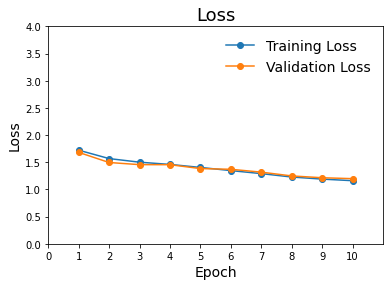

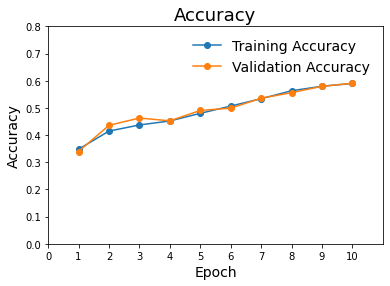

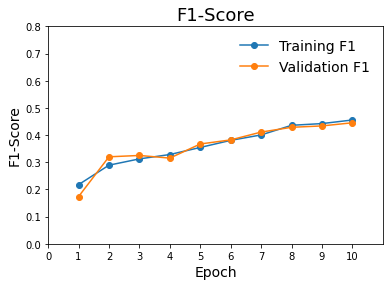

In [31]:
import matplotlib.pyplot as plt

#loss
plt.title("Loss",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss",fontsize=14)

plt.ylim(0, 4.0)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_loss,label='Training Loss',marker ='o')
plt.plot(range(1, 11),plot_valid_loss,label='Validation Loss',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

#acc
plt.title("Accuracy",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)

plt.ylim(0, 0.8)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_acc,label='Training Accuracy',marker ='o')
plt.plot(range(1, 11),plot_valid_acc,label='Validation Accuracy',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

#f1
plt.title("F1-Score",fontsize=18)
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("F1-Score",fontsize=14)

plt.ylim(0, 0.8)
plt.xlim(0, 11, 1)

plt.xticks(np.arange(0, 11, 1))
plt.plot(range(1, 11),plot_train_f1,label='Training F1',marker ='o')
plt.plot(range(1, 11),plot_valid_f1,label='Validation F1',marker ='o')
plt.legend(frameon=False, fontsize=14)

plt.show()

<a href="./new_visiontransformer.pt"> Download File </a>